In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import numpy as np
import IPython.display
from PIL import Image
import functools
import tensorflow as tf
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [2]:
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

In [3]:
content_path = 'porsche-911.jpg'
style_path = 'van_gogh.png'

In [4]:
#content_path = 'porsche-911.jpg'
#style_path = 'styles_pic/van_gogh.png'
#comic_style_path = 'styles_pic/comic.png'
#stylized_ad_style_path = 'styles_pic/stylized_ad.png'

In [5]:
def load_image(path):
    max_dim = 512
    img = Image.open(path)
    long = max(img.size)
    scale = max_dim/long
    img = img.resize(
        (round(img.size[0]*scale), round(img.size[1]*scale)))

    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img


def imshow(img, title=None):

    out = np.squeeze(img, axis=0)
    out = out.astype('uint8')
    plt.imshow(out)
    if title is not None:
        plt.title(title)
    plt.imshow(out)

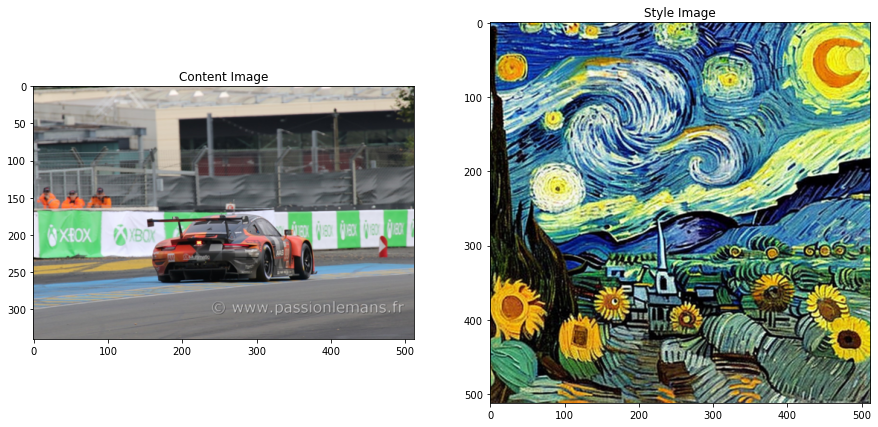

In [6]:
plt.figure(figsize=(15,15))

content = load_image(content_path).astype('uint8')
style = load_image(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

In [7]:
def load_and_process(path):
    img = load_image(path)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(processed_img):
    x = processed_img.copy()
    x = np.squeeze(x, 0)

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [8]:
# Content layer
content_layers = ['block5_conv2'] 

# Style layers
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [9]:
def get_model():  
    #Load our model. We load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    # Get output layers corresponding to style and content layers 
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    # Build model 
    return models.Model(vgg.input, model_outputs)

def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):

    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
    # height, width, num filters of each layer
    # We scale the loss at a given layer by the size of the feature map and the number of filters
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

def get_feature_representations(model, content_path, style_path):
  
    # Load our images in 
    content_image = load_and_process(content_path)
    style_image = load_and_process(style_path)

    # batch compute content and style features
    style_outputs = model(style_image)
    content_outputs = model(content_image)


    # Get the style and content feature representations from our model  
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):

    style_weight, content_weight = loss_weights


    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    # Accumulate style losses from all layers
    # Here, we equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * \
            get_style_loss(comb_style[0], target_style)

    # Accumulate content losses from all layers
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer * \
            get_content_loss(comb_content[0], target_content)

    style_score *= style_weight
    content_score *= content_weight

    # Get total loss
    loss = style_score + content_score
    return loss, style_score, content_score

def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg)
        total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

def run_style_transfer(content_path,
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3,
                       style_weight=1e-2):
    # We don't need to (or want to) train any layers of our model, so we set their
    # trainable to false.
    model = get_model()
    for layer in model.layers:
        layer.trainable = False

    # Get the style and content feature representations (from our specified intermediate layers)
    style_features, content_features = get_feature_representations(
        model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature)
                           for style_feature in style_features]

    # Set initial image
    init_image = load_and_process(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)
    # Create our optimizer
    opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

    # For displaying intermediate images
    iter_count = 1

    # Store our best result
    best_loss, best_img = float('inf'), None
    
    loss_weights = (style_weight, content_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }

    # For displaying
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations/(num_rows*num_cols)
    start_time = time.time()
    global_start = time.time()

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means
    
    imgs = []
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time()

    if loss < best_loss:
        # Update best loss and best image from total loss.
        best_loss = loss
        best_img = deprocess_image(init_image.numpy())

    if i % display_interval == 0:
        start_time = time.time()

    # Use the .numpy() method to get the concrete numpy array
    plot_img = init_image.numpy()
    plot_img = deprocess_image(plot_img)
    imgs.append(plot_img)
    IPython.display.clear_output(wait=True)
    IPython.display.display_png(Image.fromarray(plot_img))
    print('Iteration: {}'.format(i))
    print('Total loss: {:.4e}, '
          'style loss: {:.4e}, '
          'content loss: {:.4e}, '
          'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14, 4))
    for i, img in enumerate(imgs):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

    return best_img, best_loss

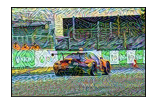

In [10]:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=50)

***RESULTS***

In [11]:
def show_results(best_img, content_path, style_path, show_large_final=True):
    plt.figure(figsize=(10, 5))
    content = load_image(content_path) 
    style = load_image(style_path)

    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')

    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')

    if show_large_final: 
        plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

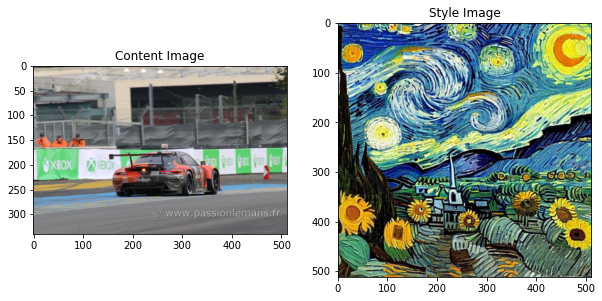

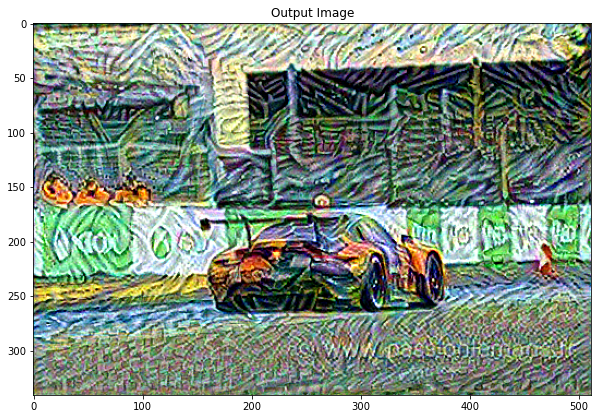

In [12]:
show_results(best, content_path, style_path)

In [13]:
custom_pic=Image.fromarray(best)
custom_pic.save("it_50_final_with_van_gogh.jpg")